In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from IPython.display import display, Markdown

disp_md = lambda text: display(Markdown(text))


## FSAE Acceleration Event Simulation

This model assumes simple friciton for tire friction

In [4]:
def motor_torque(rot_speed, voltage, current, efficiency, max_power=80e+3):
    #From Emrax 228 Manual
    torque_per_Arms = 0.75
    rpm_per_Vdc = 11

    torque = torque_per_Arms*current 
    max_speed = voltage* rpm_per_Vdc * 2*np.pi/60
    speed_limited_power = max_speed*torque

    #check power limit
    if speed_limited_power < max_power:
        max_power = speed_limited_power

    if rot_speed >= 6500* 2*np.pi/60:
        T = 0
    
    elif torque*rot_speed > max_power:
        T = efficiency * max_power/rot_speed 
    else:
        T = efficiency * torque
        
    return T, T * rot_speed
    
    

def drag_acc(speed, cda, mass, rho = 1.15):
    return (1/2) * rho * cda * speed**2 / mass
    
def max_tire_acc(rear_mass_ratio, wheelbase, cg_height, mu, g):
    return mu*rear_mass_ratio*g*wheelbase / (wheelbase-cg_height)

def max_motor_acc(mass, vehicle_speed, drive_ratio, tire_radius, voltage, current, efficiency):
    motor_speed = drive_ratio*vehicle_speed/tire_radius
    torque, power = motor_torque(motor_speed, voltage, current, efficiency)
    return torque*drive_ratio / tire_radius / mass, power
    


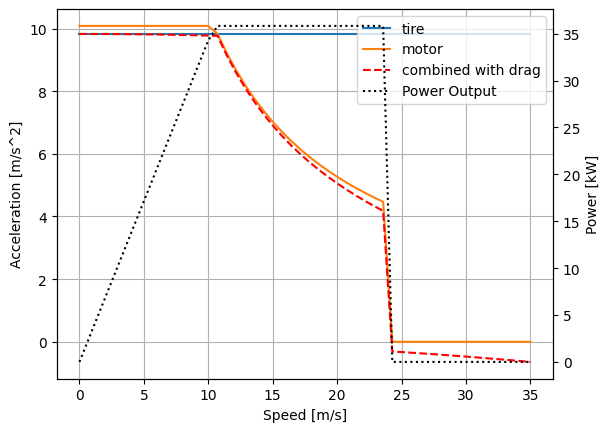

## Vehicle Parameters

All units are in SI

| Parameter | Value |
|---|---|
| mass | 340 |
| wheelbase | 1.53 |
| rear mass ratio | 0.55 |
| center of mass height | 0.27 |
| mu | 1.5 |
| drive ratio | 6 |
| tire radius | 0.21 |
| cda | 0.3101 |
| drivetrain efficiency | 0.8 |
| cell count | 72 |
| current | 200 |
| cell R | 0.003 |


In [25]:
car = {
    'mass' : 260 + 80, #kg
    'wheelbase': 1530e-3, # m
    'rear mass ratio': 0.55, # From Rough_Asm solidworks model
    'center of mass height': 270e-3, # m From Rough_Asm solidworks model
    'mu' : 1.5, #~2 from tire test data, reduced by 25% to account for surface conditions
    'drive ratio' : 6,
    'tire radius' : 210e-3, #18in diameter tires
    'cda' : 0.728*0.426, # based on Design & Development of an Aerodynamic Package for an FSAE Race Car
    'drivetrain efficiency' : 0.80,
    'cell count' : 72,
    'current' : 200, #limited by motor cables (as stated by Gavin)
    'cell R' : 3e-3, # ohms
}

voltage = car['cell count']*(4.2-car['current']*car['cell R'])
                   
# wrapper function for maximum vehicle acceleration at speed
def acceleration(speed, drive_ratio=car['drive ratio'], battery_voltage=car['cell count']*(4.2-car['current']*car['cell R']), max_current=car['current']):
    a_tire = max_tire_acc(car['rear mass ratio'], car['wheelbase'], car['center of mass height'], car['mu'], 9.81)
    a_motor, power = max_motor_acc(car['mass'], speed, drive_ratio, car['tire radius'], battery_voltage, max_current, car['drivetrain efficiency'])
    return np.min([a_tire, a_motor]) - drag_acc(speed, car['cda'], car['mass']), power              

# Plot max acceleration and power throughout vehicle speed
speed_range = np.linspace(0,35)
fig, ax1 = plt.subplots()

ax1.plot(speed_range, [max_tire_acc(car['rear mass ratio'], car['wheelbase'], car['center of mass height'], car['mu'], 9.81) for speed in speed_range], label='tire')
ax1.plot(speed_range, [max_motor_acc(car['mass'], speed, car['drive ratio'], car['tire radius'], voltage, car['current'], car['drivetrain efficiency'])[0] for speed in speed_range], label='motor' )
ax1.plot(speed_range, [acceleration(speed)[0] for speed in speed_range], label='combined with drag', color='red', linestyle='--' )
ax1.set_xlabel('Speed [m/s]')
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.grid()

# Power output on a different y-axis
ax2 = ax1.twinx()
power_curve = [acceleration(speed)[1]*1e-3 for speed in speed_range]
ax2.plot(speed_range, power_curve, label='Power Output', color='black', linestyle=':')
ax2.set_ylabel('Power [kW]', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.show()

# Display vehicle parameters as a markdown table
def vehicle_params_table(params):
    table = "| Parameter | Value |\n|---|---|\n"
    for k, v in params.items():
        try:
            val = f"{v:.4g}" if isinstance(v, float) else str(v)
        except Exception:
            val = str(v)
        table += f"| {k} | {val} |\n"
    return table

disp_md("## Vehicle Parameters")
disp_md('All units are in SI')
disp_md(vehicle_params_table(car))


### Simulate full event

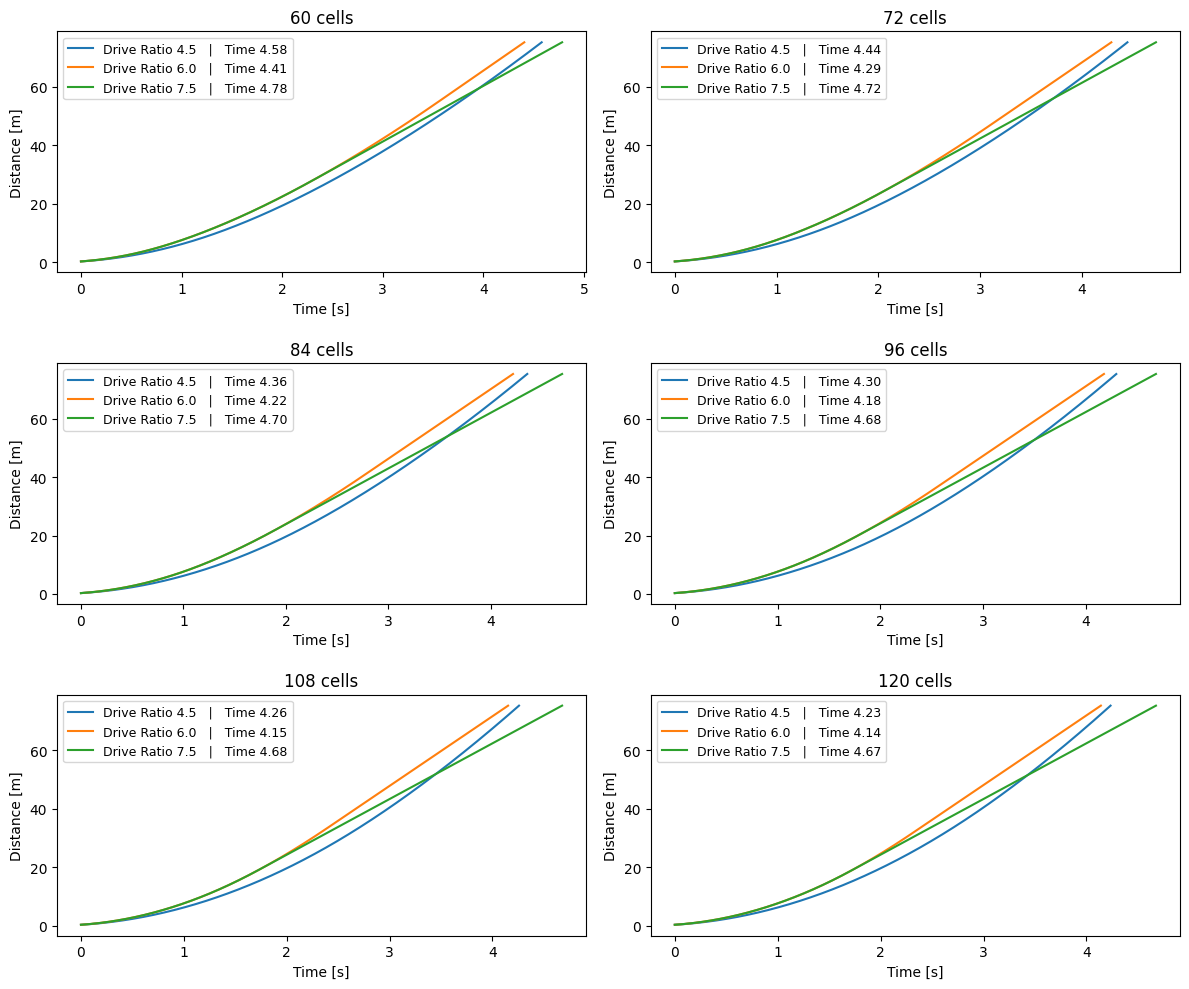

In [27]:
#Configurations to test
drive_ratios = np.linspace(4.5, 7.5, num=3)
cell_count = np.array([60, 72, 84, 96, 108, 120]) 
loaded_voltage = 4.2 - (car['current'] * car['cell R'])


#wrapper function to simulate acceleration at different drive ratios and battery voltages
def simulate_acc(ratio, voltage):
    def func(t, x):
        x, x_dot = x
        return [x_dot, acceleration(x_dot, drive_ratio=ratio, battery_voltage=voltage)[0]]
        #return [x_dot, 5-0.1*x_dot**2]

    output = solve_ivp(func, [0, 8], [0,0], max_step = 0.001)
    times = output.t
    x, v = output.y

    # Find indices where x is closest to 0.3 and 75.3
    idx_start = np.argmin(np.abs(x - 0.3))
    idx_end = np.argmin(np.abs(x - 75.3))
    times = times[idx_start:idx_end] - times[idx_start]
    x = x[idx_start:idx_end]
    v = v[idx_start:idx_end]
    return times, x

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

#Simulate and plot each scenario 
for ax, n in zip(axes, cell_count):
    for dr in drive_ratios:
        times, x = simulate_acc(dr, n*loaded_voltage)

        ax.plot(times, x, label = f'Drive Ratio {dr}   |   Time {times[-1]:.2f}')
        ax.set_title(f'{n} cells')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Distance [m]')
        ax.legend(fontsize=9)

plt.tight_layout(h_pad=1.8)


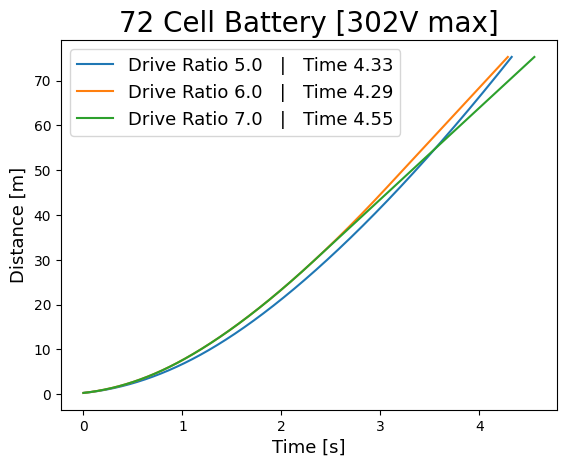

In [ ]:
#Actual Configuration
drive_ratios = np.linspace(5, 7, num=3)
cell_count = 72



for dr in drive_ratios:
    times, x = simulate_acc(dr, n*loaded_voltage)
    plt.plot(times, x, label = f'Drive Ratio {dr}   |   Time {times[-1]:.2f}')
    plt.title(f'{n} Cell Battery [302V max]', fontsize=20)
    plt.xlabel('Time [s]', fontsize=13)
    plt.ylabel('Distance [m]', fontsize=13)
    plt.legend(fontsize=13)

